## CUDA and SPLIT


In [10]:
from torch.utils.data import DataLoader
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset

import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
SPLIT_BY = 'actor'

## normalize

In [12]:
from statMLlib import DatasetWrapper 
import imp
imp.reload(DatasetWrapper)
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset
from torch.utils.data import DataLoader

class StatsRecorder:
    def __init__(self, red_dims=(0,1,2)):
        """Accumulates normalization statistics across mini-batches.
        ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """
        self.red_dims = red_dims # which mini-batch dimensions to average over
        self.nobservations = 0   # running number of observations

    def update(self, data):
        """
        data: ndarray, shape (nobservations, ndimensions)
        """
        # initialize stats and dimensions on first batch
        if self.nobservations == 0:
            self.mean = data.mean(dim=self.red_dims, keepdim=True)
            self.std  = data.std (dim=self.red_dims,keepdim=True)
            self.nobservations = data.shape[0]
            self.ndimensions   = data.shape[1]
        else:
            if data.shape[1] != self.ndimensions:
                raise ValueError('Data dims do not match previous observations.')
            
            # find mean of new mini batch
            newmean = data.mean(dim=self.red_dims, keepdim=True)
            newstd  = data.std(dim=self.red_dims, keepdim=True)
            
            # update number of observations
            m = self.nobservations * 1.0
            n = data.shape[0]

            # update running statistics
            tmp = self.mean
            self.mean = m/(m+n)*tmp + n/(m+n)*newmean
            self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
                        m*n/(m+n)**2 * (tmp - newmean)**2
            self.std  = torch.sqrt(self.std)
                                 
            # update total number of seen samples
            self.nobservations += n


root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/1d-cnn/'

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=8, shuffle=True)

# create recorders
global_stats  = StatsRecorder()
channel_stats = StatsRecorder(red_dims=(0,1))

# step through the training dataset
with torch.no_grad():
    
    for idx,(x,y) in enumerate(iter(train_dataloader)):
        # print(x.shape)
        # print((torch.mean(x, axis=1)))
        # update normalization statistics
        # x=(x-torch.mean(x))/torch.std(x)
        global_stats.update(x)
        channel_stats.update(x)
    
# parse out both sets of stats
global_mean,global_std = global_stats.mean,global_stats.std
global_mean=global_mean.squeeze(0)
global_std=global_std.squeeze(0)


channel_mean,channel_std = channel_stats.mean,channel_stats.std
channel_mean=channel_mean.squeeze(0)
channel_std=channel_std.squeeze(0)

print(f'Shape of global mean: {global_mean.shape}')
print(f'Shape of global standard dev: {global_std.shape}')

print(f'Shape of channel mean: {channel_mean.shape}')
print(f'Shape of channel standard dev: {channel_std.shape}')
# print(channel_mean)
global_mean.to(DEVICE)
global_std.to(DEVICE)

channel_mean.to(DEVICE)
channel_std.to(DEVICE)

# print(channel_std)
pass


Shape of global mean: torch.Size([1, 1])
Shape of global standard dev: torch.Size([1, 1])
Shape of channel mean: torch.Size([1, 180])
Shape of channel standard dev: torch.Size([1, 180])


## check sample

torch.Size([16, 1, 180])
tensor(0.2351, device='cuda:0')


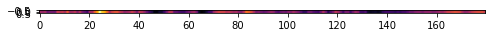

In [13]:
from statMLlib import DatasetWrapper 
import imp
imp.reload(DatasetWrapper)
from statMLlib.DatasetWrapper import RAVDESSFeatureDataset


from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 

root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/1d-cnn/'

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=channel_mean, std= channel_std)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=16, shuffle=True)


imput_dim=(None,None)

for src, tgt in train_dataloader:
    src = src.to(DEVICE)
    tgt = tgt.to(DEVICE)
    
    print(src.shape)
    
    imput_dim=(src.shape[1], src.shape[2])
#     print(tgt.shape)
#     print(torch.mean(src, axis=1).shape)
    

    print(torch.mean(src[0][0]))
    fig=plt.figure(figsize=(8, 8))
    # plt.plot(src.cpu().numpy()[1])
    imgplot = plt.imshow(src.cpu().numpy()[1], cmap=plt.get_cmap( 'inferno'))
    
    # print(std)
    # print(src.cpu().numpy()[5])

    break
    
    





## Train Eval functions

In [14]:

root_features='/home/spongebob*/statML_project/RAVDESS/RAVDESS-emotions-speech-audio-only-master/Audio_Speech_Actors_01-24/FeaturesAll/1d-cnn/'

def train_epoch(model, optimizer):
    model.train()
    losses = 0

    train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
#         if(NORM=='channel'):
#             mean=channel_mean.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
#             std=channel_std.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
        
#         elif NORM == 'global':
#             mean=global_mean.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
#             std=global_std.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
            
#         else:
#             mean=torch.tensor(0).to(DEVICE)
#             std=torch.tensor(1).to(DEVICE)
            
#         # src=(src-torch.mean(src, axis=1))/torch.std(src, axis=1)
#         src_norm=(src-mean)/std
        
        logits = model(src)
        # print(logits.shape)

        optimizer.zero_grad()
        
       

        loss = loss_fn(logits, tgt)
        # print(loss)
        # loss = loss_fn(logits, tgt_out)

        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    
    val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, shuffle=True)
    
    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
#         if NORM=='channel':
#             mean=channel_mean.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
#             std=channel_std.repeat(src.shape[0],1,src.shape[2]).to(DEVICE)
        
#         elif NORM == 'global':
#             mean=global_mean.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
#             std=global_std.repeat(src.shape[0],src.shape[1],src.shape[2]).to(DEVICE)
            
#         else:
#             mean=torch.tensor(0).to(DEVICE)
#             std=torch.tensor(1).to(DEVICE)
            
#         # src=(src-torch.mean(src))/torch.std(src)
#         src_norm=(src-mean)/std

        logits = model(src)
  
        loss = loss_fn(logits, tgt)
     
        losses += loss.item()
    
    
    
    return losses / len(val_dataloader)

# MLP

In [15]:


class Ravdess_MLP(nn.Module):

    def __init__(self, input_size, tgt_class_cnt, num_of_layers):
        super(Ravdess_MLP, self).__init__()
        # an affine operation: y = Wx + b
        self.input_size=input_size
        self.tgt_class_cnt=tgt_class_cnt
        
        self.hidden_dim=input_size*4#int(self.input_size/2)
                               
        self.linear_relu_stack1 = nn.Sequential(

           
            nn.Linear(input_size, int(self.hidden_dim/2)),
            nn.BatchNorm1d(int(self.hidden_dim/2)),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(int(self.hidden_dim/2), self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            # nn.Dropout(0.1),
        )
        
#         self.hidden = []
#         for k in range(num_of_layers):
#             self.hidden.append(nn.Linear(self.hidden_dim, self.hidden_dim))
#             self.hidden.append(nn.BatchNorm1d(self.hidden_dim))
#             self.hidden.append(nn.ReLU())
#             # self.hidden.append(nn.Dropout(0.1))


#         self.linear_relu_stack2 = nn.Sequential(*self.hidden)
        
        self.linear_relu_stack3 = nn.Sequential(
  
            # nn.Linear(self.hidden_dim, int(self.hidden_dim)),
            # nn.BatchNorm1d(int(self.hidden_dim)),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(int(self.hidden_dim), int(self.hidden_dim/2)),
            nn.BatchNorm1d(int(self.hidden_dim/2)),
            nn.ReLU(),
            nn.Dropout(0.2),
            
#             nn.Linear(int(self.hidden_dim/4), int(self.hidden_dim/8)),
#             nn.BatchNorm1d(int(self.hidden_dim/8)),
#             nn.ReLU(),
            # nn.Dropout(0.1),
            
            nn.Linear(int(self.hidden_dim/2), tgt_class_cnt)
  
#             nn.Dropout(0.5),
           

        )
   
    def forward(self, x):
       
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.linear_relu_stack1(x)
        # x = self.linear_relu_stack2(x)
        x = self.linear_relu_stack3(x)
        

        return x




In [16]:
from torchsummary import summary

INPUT_SIZE=imput_dim[0]*imput_dim[1]
TGT_CLASS_CNT=8

mlp = Ravdess_MLP(input_size=INPUT_SIZE, tgt_class_cnt=TGT_CLASS_CNT, num_of_layers=2)
# print(mlp)
# params = list(mlp.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

summary(mlp)
print(mlp)
for p in mlp.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

mlp = mlp.to(DEVICE)

# loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       65,160
|    └─BatchNorm1d: 2-2                  720
|    └─ReLU: 2-3                         --
|    └─Linear: 2-4                       259,920
|    └─BatchNorm1d: 2-5                  1,440
|    └─ReLU: 2-6                         --
|    └─Dropout: 2-7                      --
|    └─Linear: 2-8                       519,120
|    └─BatchNorm1d: 2-9                  1,440
|    └─ReLU: 2-10                        --
├─Sequential: 1-2                        --
|    └─Linear: 2-11                      259,560
|    └─BatchNorm1d: 2-12                 720
|    └─ReLU: 2-13                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      2,888
Total params: 1,110,968
Trainable params: 1,110,968
Non-trainable params: 0
Ravdess_MLP(
  (linear_relu_stack1): Sequential(
    (0): Linear(in_features=180, out_features=36

In [17]:
from timeit import default_timer as timer
import wandb


NUM_EPOCHS = 18
NORM='global'#'channel'
BATCH_SIZE = 8 #128

if NORM=='channel':
    MEAN=channel_mean
    STD=channel_std
elif NORM=='global':
    MEAN=global_mean
    STD=global_std
else:
    MEAN=0
    STD=1

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.0001, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(mlp, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(mlp, optimizer)
    end_time = timer()
    # if epoch%10==0:
    #     PATH=f"checkpoints/checkpoint_{epoch}.pt"
    #     torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': transformer.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': train_loss,
    #             }, PATH)
    val_loss = evaluate(mlp)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
    

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



wandb: Currently logged in as: mohnik (use `wandb login --relogin` to force relogin)


Epoch: 1, Train loss: 2.188, Val loss: 1.720, Epoch time = 0.514s
Epoch: 2, Train loss: 1.860, Val loss: 1.623, Epoch time = 0.499s
Epoch: 3, Train loss: 1.727, Val loss: 1.559, Epoch time = 0.498s
Epoch: 4, Train loss: 1.652, Val loss: 1.542, Epoch time = 0.500s
Epoch: 5, Train loss: 1.557, Val loss: 1.520, Epoch time = 0.506s
Epoch: 6, Train loss: 1.485, Val loss: 1.488, Epoch time = 0.521s
Epoch: 7, Train loss: 1.426, Val loss: 1.474, Epoch time = 0.525s
Epoch: 8, Train loss: 1.314, Val loss: 1.440, Epoch time = 0.500s
Epoch: 9, Train loss: 1.317, Val loss: 1.525, Epoch time = 0.512s
Epoch: 10, Train loss: 1.343, Val loss: 1.488, Epoch time = 0.502s
Epoch: 11, Train loss: 1.242, Val loss: 1.444, Epoch time = 0.514s
Epoch: 12, Train loss: 1.206, Val loss: 1.423, Epoch time = 0.516s
Epoch: 13, Train loss: 1.206, Val loss: 1.449, Epoch time = 0.532s
Epoch: 14, Train loss: 1.135, Val loss: 1.490, Epoch time = 0.561s
Epoch: 15, Train loss: 1.143, Val loss: 1.484, Epoch time = 0.540s
Epoc

(1140,)
[[ 75.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 122.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 126.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 129.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 151.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 137.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 113.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 144.]]
(300,)


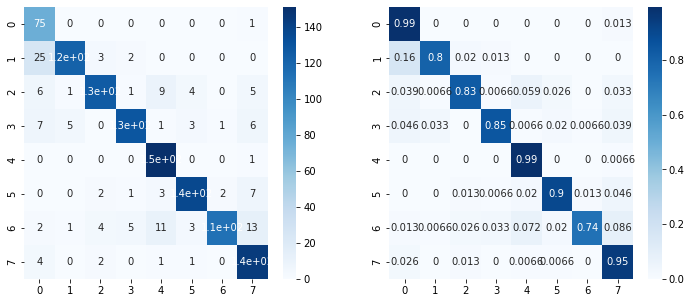

Train accuracy: 0.874561403508772


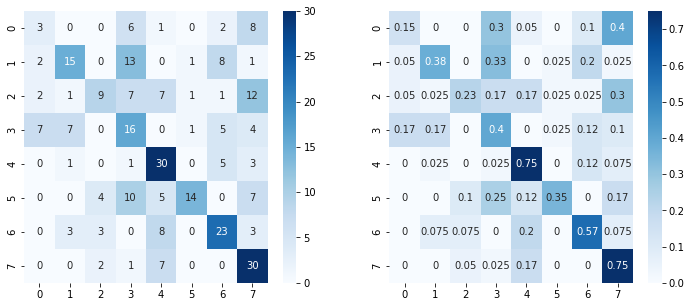

Val accuracy: 0.4666666666666667


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    # print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=1, shuffle=True)
    
train_cm = get_confusion_matrix(mlp,train_dataloader)
train_acc = (train_cm*np.eye(len(train_cm))).sum()/np.sum(train_cm)

print(train_cm*np.eye(len(train_cm)))
val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=1, shuffle=True)
    
val_cm = get_confusion_matrix(mlp,val_dataloader)
val_acc = (val_cm*np.eye(len(val_cm))).sum()/np.sum(val_cm)



plot_cm(train_cm)
print(f'Train accuracy: {train_acc}')

plot_cm(val_cm)
print(f'Val accuracy: {val_acc}')


## 1D CNN

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Ravdess_CNN_1D(nn.Module):
    def __init__(self, input_size, tgt_class_cnt, num_of_layers=None):
        super(Ravdess_CNN_1D, self).__init__()
        # an affine operation: y = Wx + b
        self.input_size=input_size
        self.tgt_class_cnt=tgt_class_cnt
        
        # self.hidden_dim=int(self.input_size/2)

        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel 
        self.conv1 = nn.Conv1d(1, 32, 5,stride=2, padding=0)
        
        # self.conv2 = nn.Conv1d(32, 32, 5,stride=1, padding=0)

        self.conv3 = nn.Conv1d(32, 32, 5,stride=1, padding=0)

        self.conv4 = nn.Conv1d(32, 64, 3,stride=1, padding=0)

        # self.conv5 = nn.Conv1d(64, 128, 3,stride=1, padding=0)

        self.conv6 = nn.Conv1d(64, 64, 2, stride=1, padding=0)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64, 128)  # 5*5 from image dimension
        self.fc2 = nn.Linear(128, tgt_class_cnt)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool1d(F.relu(self.conv1(x)), 1)
        # x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 1)
        x = F.max_pool1d(F.relu(self.conv4(x)), 2)
        # x = F.max_pool1d(F.relu(self.conv5(x)), 2)
        x = F.adaptive_max_pool1d(F.relu(self.conv6(x)), 1)
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x




In [20]:
from torchsummary import summary

INPUT_SIZE=INPUT_SIZE=imput_dim[0]*imput_dim[1]
TGT_CLASS_CNT=8
BATCH_SIZE = 64 #128

cnn_1d = Ravdess_CNN_1D(input_size=INPUT_SIZE, tgt_class_cnt=TGT_CLASS_CNT)
# print(mlp)
# params = list(mlp.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

summary(cnn_1d)

for p in cnn_1d.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

cnn_1d = cnn_1d.to(DEVICE)
print(cnn_1d)
# loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_1d.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            192
├─Conv1d: 1-2                            5,152
├─Conv1d: 1-3                            6,208
├─Conv1d: 1-4                            8,256
├─Linear: 1-5                            8,320
├─Linear: 1-6                            1,032
Total params: 29,160
Trainable params: 29,160
Non-trainable params: 0
Ravdess_CNN_1D(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(2,))
  (conv3): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (conv6): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)


In [21]:
from timeit import default_timer as timer
import wandb


NUM_EPOCHS = 100
NORM=None

if NORM=='channel':
    MEAN=channel_mean
    STD=channel_std
elif NORM=='global':
    MEAN=global_mean
    STD=global_std
else:
    MEAN=0
    STD=1

# start a new experiment
wandb.init(project="statML", entity="mohnik")

# capture a dictionary of hyperparameters with config
wandb.config = {"learning_rate": 0.0001, "epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE}

wandb.watch(cnn_1d, loss_fn, log='all', log_freq=20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(cnn_1d, optimizer)
    end_time = timer()
    # if epoch%10==0:
    #     PATH=f"checkpoints/checkpoint_{epoch}.pt"
    #     torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': transformer.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': train_loss,
    #             }, PATH)
    val_loss = evaluate(cnn_1d)
     # Where the magic happens
    wandb.log({"epoch": epoch, "train_loss": [train_loss, val_loss], "val_loss": val_loss})
    

    # Optional
    # wandb.watch(mlp)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    
    



epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁
val_loss,█▆▄▄▃▃▂▁▃▃▂▁▂▃▂▂▄▂
epoch,18
train_loss,1.07143
val_loss,1.48325


Epoch: 1, Train loss: 2.063, Val loss: 2.033, Epoch time = 0.182s
Epoch: 2, Train loss: 2.036, Val loss: 2.018, Epoch time = 0.191s
Epoch: 3, Train loss: 2.020, Val loss: 2.002, Epoch time = 0.192s
Epoch: 4, Train loss: 2.003, Val loss: 1.989, Epoch time = 0.173s
Epoch: 5, Train loss: 1.987, Val loss: 1.972, Epoch time = 0.168s
Epoch: 6, Train loss: 1.969, Val loss: 1.959, Epoch time = 0.169s
Epoch: 7, Train loss: 1.952, Val loss: 1.944, Epoch time = 0.167s
Epoch: 8, Train loss: 1.934, Val loss: 1.927, Epoch time = 0.172s
Epoch: 9, Train loss: 1.916, Val loss: 1.908, Epoch time = 0.171s
Epoch: 10, Train loss: 1.896, Val loss: 1.898, Epoch time = 0.165s
Epoch: 11, Train loss: 1.875, Val loss: 1.872, Epoch time = 0.161s
Epoch: 12, Train loss: 1.856, Val loss: 1.854, Epoch time = 0.166s
Epoch: 13, Train loss: 1.834, Val loss: 1.835, Epoch time = 0.170s
Epoch: 14, Train loss: 1.814, Val loss: 1.812, Epoch time = 0.171s
Epoch: 15, Train loss: 1.795, Val loss: 1.799, Epoch time = 0.167s
Epoc

(1140, 1)
(1140,)
[[ 43.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 121.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  95.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  90.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 113.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 116.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 105.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 140.]]
(300, 1)
(300,)


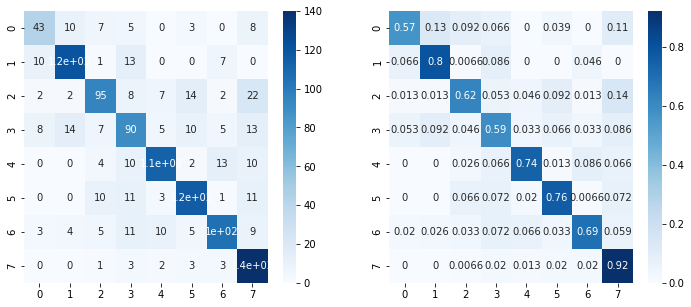

Train accuracy: 0.7219298245614035


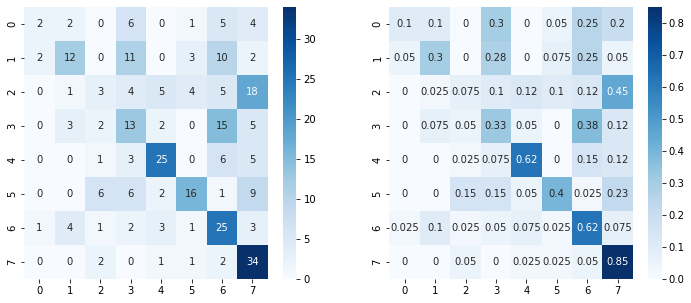

Val accuracy: 0.43333333333333335


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def get_confusion_matrix(mdl, dataloader):
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        mdl.eval()
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            # print(src.shape)
            outputs = mdl(src)
            # labels = labels.argmax(1)
            predicted = outputs.argmax(1)
            y_pred.append(predicted.cpu().numpy())
            y_true.append(tgt.cpu().numpy())
            

            total += len(src)
            correct += (tgt == predicted).sum().item()
    print(np.shape(y_true))
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    print(np.shape(y_true))
    cm = confusion_matrix(y_true, y_pred)
    return cm

def plot_cm(cm):
    f, axs = plt.subplots(1,2, figsize=(12,5))
    sns.heatmap(cm, annot=True, cmap='Blues', ax=axs[0])
    sns.heatmap(cm/cm.sum(1).reshape(-1,1), annot=True, cmap='Blues', ax=axs[1])
    plt.show()
    

train_iter = RAVDESSFeatureDataset(split='train',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=1, shuffle=True)
    
train_cm = get_confusion_matrix(cnn_1d,train_dataloader)
train_acc = (train_cm*np.eye(len(train_cm))).sum()/np.sum(train_cm)

print(train_cm*np.eye(len(train_cm)))
val_iter = RAVDESSFeatureDataset(split='valid',split_by=SPLIT_BY, root_dir=root_features, mean=MEAN, std= STD)#Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=1, shuffle=True)
    
val_cm = get_confusion_matrix(cnn_1d,val_dataloader)
val_acc = (val_cm*np.eye(len(val_cm))).sum()/np.sum(val_cm)



plot_cm(train_cm)
print(f'Train accuracy: {train_acc}')

plot_cm(val_cm)
print(f'Val accuracy: {val_acc}')
